### This post will try to explain the differences between KL and reverse KL divergences and demonstrate it using a small generative model trained on mixture of gaussian dataset. I will be using JAX to demonstrate this example!


In [1]:
from __future__ import print_function
import jax
import jax.numpy as np
from jax import jit
import random
import numpy as onp
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import matplotlib.patches as mpatches

### Create mixture of gaussian data

In [3]:
p = 0.75
batch_size=64
mean_std = [[[0.5,2],[[4,0],[0,1.5]], p], [[9,9],[[1,0],[0,3]],1-p]]

def create_mixture_of_gaussian(batch_size, mean_var):
    nb_samples = batch_size
    data = [onp.random.multivariate_normal(params[0], params[1], int(nb_samples*params[2])) for params in mean_var]
    return onp.vstack(data)

def plot_dataset(ax, data, size=4, cmap="Reds", label="Ground truth"):
    ax.set_aspect('equal')
    ax.set_ylim((0, size))
    ax.set_xlim((0, size))
    ax.tick_params(labelsize=10)
    sns.kdeplot(
        data[:, 0],
        data[:, 1],
        cmap=cmap,
        ax=ax,
        )
    
data_indices = [create_mixture_of_gaussian(batch_size, mean_std) for _ in range(10000)]
data = onp.vstack([d for d in data_indices])
data = (data - onp.min(data))/(onp.max(data) - onp.min(data))

### First, lets use MLE to estimate parameters of a Gaussian that fits the underlying data distribution

Maximum Likelihood Estimation to estimate parameters of a gaussian distribution:
$$\mu_{ML} = \frac{1}{N} \sum_{n=1}^{N} x_{n}$$
$$\Sigma_{ML} = \frac{1}{N} \sum_{n=1}^{N} (x_{n} - \mu)(x_{n} - \mu)^T$$

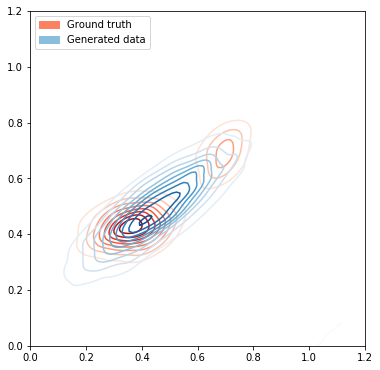

In [4]:
# Plot the ground truth data
fig, ax = plt.subplots(figsize=(6, 12))
plot_dataset(ax, data[:1000], size=1)

# Estimate the mean and covariance from data
mu_estimate = onp.mean(data, axis=0)
covar_estimate = onp.matmul(onp.transpose(data - mu_estimate),(data-mu_estimate)) / data.shape[0]
mean_var_estimate = [[mu_estimate, covar_estimate, 1.0]]

# Generate data from estimated mean and variance
gen_data_indices = [create_mixture_of_gaussian(batch_size, mean_var_estimate) for _ in range(100)]
generated_data = onp.vstack([d for d in gen_data_indices])
plot_dataset(ax, generated_data, size=1.2, cmap="Blues", label='Generated data')

# Add legends to the plot
groundtruth_patch = mpatches.Patch(color=sns.color_palette("Reds")[2], label="Ground truth")
gendata_patch = mpatches.Patch(color=sns.color_palette("Blues")[2], label="Generated data")
ax.legend(handles=[groundtruth_patch, gendata_patch], loc="upper left")

Kullback-Leibler divergence (KL divergence) is a measure of the information lost when q(x)is used to approximate p(x), where both p(x) and q(x) are probability distributions.  

$$D_{KL}(P||Q) = \mathbf{E}_{x\backsim\ p} \bigg[log \frac{P(X)}{Q(X)}\bigg]$$
The above equation can be further transformed to :
$$D_{KL}(P||Q) = \mathbf{E}_{x\backsim\ p} \big[log P(X)\big] - \mathbf{E}_{x\backsim\ p} \big[logQ(X)\big]$$

$$D_{KL}(P||Q) = \mathbf{E}_{x\backsim\ p} \big[-log Q(X)\big] - H(P(X))$$ 

The expected value term ($\mathbf{E}_{x\backsim\ p} \big[-log Q(X)\big]$) refers to the cross entropy between P and Q and the second term $H(P(X))$ represents the entropy of probability distribution P. Having high entropy value encourages the model to spread out the probability mass instead of collapsing to a single point.

P(X) is the true data distribution, which in our case is represented by mixture of gaussians and we will try to estimate P(X) using a model that is parametrized by $\theta$. 

#### Forward KL:
Our goal here is to minimize the KL divergence between P(X) and $Q_{\theta}(X)$ such that there is minimum information loss and Q(X) best approximates the underlying data distribution.

$$\theta^{*} = \operatorname*{argmin}_\theta D_{KL}(P(x)||Q_{\theta}(x)) $$
$$\theta^{*} =  \operatorname*{argmin}_\theta  \mathbf{E}_{x\backsim\ p} \big[-log Q(X)\big] - H(P(X)$$
$$\theta^{*} =  \operatorname*{argmin}_\theta  \mathbf{E}_{x\backsim\ p} \big[-log Q(X)\big] $$


From the above simplification we know that derivative of H(P(x)) with respect to $\theta$ is 0 and hence the only term to minimize is ($\mathbf{E}_{x\backsim\ p} \big[-log Q(X)\big]$) which is equivalent to maximum likelihood estimation objective. This objective samples points from P(x) and maximizes the likelihood of these points under Q(x). Forward KL divergence forces the Q(x) distribution to spread out to cover as much points as possible under P(X). 


#### Reverse KL:
We can state the reverse KL objective as :
$$\theta^{*} = \operatorname*{argmin}_\theta D_{KL}(Q_{\theta}(x)||P(x)) $$
$$\theta^{*} =  \operatorname*{argmin}_\theta  \mathbf{E}_{x\backsim\ Q_{\theta}} \big[-log P(X)\big] - H(Q_{\theta}(X))$$

The above objective samples points from $Q_{\theta}(x)$ and tries to maximize the likelihood of these points under P(x). Here the entropy term prevents $Q_{\theta}(x)$ to collapse to a single point. Reverse KL does not require Q(x) to cover all points under P(x) and just requires points under Q(x) to have high likelihood under P(x).

Using reverse-KL is difficult in practice because in real world problems we don't have the true underlying distribution P(x) and hence can not evaluate the term $\mathbf{E}_{x\backsim\ Q_{\theta}} \big[-log P(X)\big]$. As mentioned in [1][2], we can use GAN which can allow minimization of divergences which are otherwise impossible to minimize directly. 

### Lets create a simple model

In [5]:
from jax.experimental import stax
from jax import random
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Sigmoid, Tanh, Flatten, LogSoftmax, Softplus, LeakyRelu # neural network layers
from jax.experimental import optimizers
from jax import jit, grad

eps = 1e-10

reverse_kl=True

def loss_function(output, y): # Reverse KL
    return -np.mean(-y*np.exp(output) + (1 - y)*(output + eps + 1.), axis=0)[0] # Reverse KL divergence
    #return -np.mean(y*output - (1. - y)*(np.exp(output - 1.)), axis=0)[0] # KL divergence
        
def gen_loss(generator_params, discriminator_params, noise, y, reverse_kl=False):
    gen_out = generator_net_apply(generator_params, noise)
    prediction = discriminator_net_apply(discriminator_params, gen_out)
    return loss_function(prediction, y)
    
def disc_loss(p, x, y):
    prediction = discriminator_net_apply(p, x)
    loss_value = loss_function(prediction, y)
    return loss_value

@jit
def generator_step(i, disc_opt_state, gen_opt_state, noise, y):
    generator_params = gen_get_params(gen_opt_state)
    discriminator_params = disc_get_params(disc_opt_state)
    g = grad(gen_loss)(generator_params, discriminator_params, noise, y)
    return gen_opt_update(i, g, gen_opt_state)

@jit
def discriminator_step(i, opt_state, x, y):
    p = disc_get_params(opt_state)
    g = grad(disc_loss)(p, x, y)
    return disc_opt_update(i, g, opt_state)

def sample_generator(gen_opt_state, input_data):
    gen_param = gen_get_params(gen_opt_state)
    return generator_net_apply(gen_param, input_data)

def train_discriminator(i, disc_opt_state, real_data, fake_data):
    disc_opt_state = discriminator_step(i, disc_opt_state, real_data, np.ones((real_data.shape[0],1), dtype=np.float32))    
    disc_opt_state = discriminator_step(i, disc_opt_state, fake_data, np.zeros((real_data.shape[0],1), dtype=np.float32))   
    return disc_opt_state

def train_generator(i, disc_opt_state, gen_opt_state, noise):    
    gen_opt_state = generator_step(i, disc_opt_state, gen_opt_state, noise, np.ones((noise.shape[0],1), dtype=np.float32))
    return gen_opt_state

In [23]:
generator_net_init, generator_net_apply = stax.serial(
        Dense(2), Sigmoid
)

discriminator_net_init, discriminator_net_apply = stax.serial(
        Dense(32), LeakyRelu,
        Dense(32), LeakyRelu,
        Dense(1), Sigmoid
)
latent_size = 10
key = random.PRNGKey(onp.random.randint(0,999999))
key, subkey = random.split(key)
generator_in_shape = (-1, latent_size)
generator_out_shape, generator_net_params = generator_net_init(subkey, generator_in_shape)

key, subkey = random.split(key)
discriminator_in_shape = (-1, 2)
discriminator_out_shape, discriminator_net_params = discriminator_net_init(subkey, discriminator_in_shape)

In [24]:
# Initialize adam optimizer for generator and discriminator
gen_opt_init, gen_opt_update, gen_get_params = optimizers.adam(step_size=1e-4)
gen_opt_state = gen_opt_init(generator_net_params)

disc_opt_init, disc_opt_update, disc_get_params = optimizers.adam(step_size=5e-4)
disc_opt_state = disc_opt_init(discriminator_net_params)

In [26]:
batch_size = 64
for i in range(7000):
    real_data = data[onp.random.choice(data.shape[0], size=batch_size)]    
    noise = onp.random.uniform(size=(batch_size, latent_size))
    fake_data = sample_generator(gen_opt_state, noise)

    # Train discriminator
    disc_opt_state = train_discriminator(i, disc_opt_state, real_data, fake_data)    
    # Train generator
    gen_opt_state = train_generator(i, disc_opt_state, gen_opt_state, noise)    
    if i % 2000 == 0:
        print(i)
    

0
2000
4000
6000


Plotting with KL divergence loss


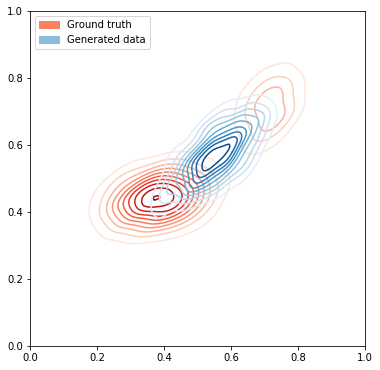

In [14]:
# Plot the ground truth data
fig, ax = plt.subplots(figsize=(6, 12))
plot_dataset(ax, data[:1000], size=1)

noise = onp.random.uniform(size=(1000, latent_size))
# Generate data from GAN
#print(noise)
generated_data = sample_generator(gen_opt_state, noise)
plot_dataset(ax, generated_data, size=1, cmap="Blues", label='Generated data')

# Add legends to the plot
groundtruth_patch = mpatches.Patch(color=sns.color_palette("Reds")[2], label="Ground truth")
gendata_patch = mpatches.Patch(color=sns.color_palette("Blues")[2], label="Generated data")
ax.legend(handles=[groundtruth_patch, gendata_patch], loc="upper left")
print("Plotting with KL divergence loss")

Plotting with reverse KL divergence loss


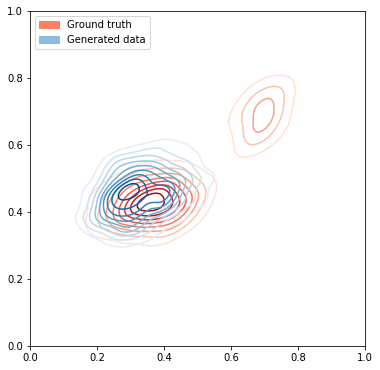

In [27]:
# Plot the ground truth data
fig, ax = plt.subplots(figsize=(6, 12))
plot_dataset(ax, data[:1000], size=1)

noise = onp.random.uniform(size=(1000, latent_size))
# Generate data from GAN
#print(noise)
generated_data = sample_generator(gen_opt_state, noise)
plot_dataset(ax, generated_data, size=1, cmap="Blues", label='Generated data')

# Add legends to the plot
groundtruth_patch = mpatches.Patch(color=sns.color_palette("Reds")[2], label="Ground truth")
gendata_patch = mpatches.Patch(color=sns.color_palette("Blues")[2], label="Generated data")
ax.legend(handles=[groundtruth_patch, gendata_patch], loc="upper left")
print("Plotting with reverse KL divergence loss")

#### References 
1. https://colinraffel.com/blog/gans-and-divergence-minimization.html
2. https://github.com/google/jax
3. https://arxiv.org/abs/1606.00709